In [1]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from definitions import TISSUES
from sklearn.preprocessing import StandardScaler

# Code for TCGA dataset

This notebook will illustrate how to run the code for the analysis using the TCGA 33 tissues. Code is repeated across different sections on purpose, so anyone can focus and edit specific sections at will.

First, we need to transform TCGA's gene expression to the same format as used for GTEx in the paper: retain only protein-encoding genes, convert ENSEMBL IDs to gene IDs, and z-score each gene samples on each tissue. Resulting CSVs from this part will be stored in `data_filtered/` folder.

Next, TCGA gene expression is inputted to the UMAP embeddings trained using GTEx data. TCGA data needs to go over some transformations so UMAP received the input in a similar format.

Finally, we calculate UMAP embeddings using only TCGA tissues, in a similar way to what was previously done with GTEx.

## 1. Mimic the pipeline done in GTEx

First, the function `generate_csv` is defined to run the pipeline code that was run in GTEx (i.e., filter non protein-encoding genes, convert to gene IDs, and z-score the values)

In [2]:
# 1
text_file = open("meta_data/uniq_protein_encoding_genes.txt", "r")
protein_genes = text_file.read().split('\n')
text_file.close()
protein_genes = [x.split('.')[0] for x in protein_genes]

# 2
convert_list = pd.read_csv("meta_data/genes_ENSEMBL_to_official_gene.csv", header=None)
convert_list.columns = ["ensemble", "doubt", "geneid"]
convert_list.set_index("ensemble", inplace=True)
convert_list.drop(columns=['doubt'], inplace=True)
old_names = convert_list.index.values
new_names = convert_list['geneid'].values

def generate_csv(tcga_path, csv_saving_name):
    print('For', csv_saving_name, ':')
    tcga_df = pd.read_csv(tcga_path, sep='\t', index_col=0).transpose()
    
    # 1 - filter out non protein-encoding genes
    common = [x for x in tcga_df.columns.values if x.split('.')[0] in protein_genes]
    tcga_df = tcga_df.loc[:, common]
    print(tcga_df.shape)
    
    # 2 - Converting ensemble to gene IDs
    print("Columns: " + str(len(tcga_df.columns.values)))
    print("Unique columns: " + str(len(np.unique(tcga_df.columns.values))))

    tcga_df = tcga_df.rename(columns=lambda x: x.split('.')[0])  # remove numbers after the point
    print("Columns after removing point: " + str(len(tcga_df.columns.values)))
    print("Unique columns after removing point: " + str(len(np.unique(tcga_df.columns.values))))

    tcga_df = tcga_df.rename(columns=dict(zip(old_names, new_names)))
    print("Columns after translation: " + str(len(tcga_df.columns.values)))
    print("Unique columns after translation: " + str(len(np.unique(tcga_df.columns.values))))

    tcga_df = tcga_df.loc[:, ~tcga_df.columns.duplicated()]
    print("Columns after removing duplicates: " + str(len(tcga_df.columns.values)))
    print("Unique columns after removing duplicates: " + str(len(np.unique(tcga_df.columns.values))))

    # Removing columns that were not translated
    to_filter = tcga_df.filter(like="ENSG", axis=1).columns.values
    tcga_df.drop(columns=to_filter, inplace=True)
    
    print(tcga_df.shape)

    # z-score each gene
    tcga_df = pd.DataFrame(StandardScaler().fit_transform(tcga_df), index=tcga_df.index, columns=tcga_df.columns)
    
    tcga_df.to_csv("data_filtered/only_geneids_" + csv_saving_name + ".csv")

### Running the function for each TCGA case

In [11]:
TCGA_TISSUES = ['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']

TCGA_PATHS = [(name_tissue, f'../tcga_tissues/TCGA-{name_tissue}.htseq_fpkm.tsv') for name_tissue in TCGA_TISSUES]

In [4]:
for name_t, path_t in TCGA_PATHS:
    generate_csv(path_t, name_t)

For ACC :
(79, 19198)
Columns: 19198
Unique columns: 19198
Columns after removing point: 19198
Unique columns after removing point: 19198
Columns after translation: 19198
Unique columns after translation: 19196
Columns after removing duplicates: 19196
Unique columns after removing duplicates: 19196
(79, 18797)
For BLCA :
(430, 19198)
Columns: 19198
Unique columns: 19198
Columns after removing point: 19198
Unique columns after removing point: 19198
Columns after translation: 19198
Unique columns after translation: 19196
Columns after removing duplicates: 19196
Unique columns after removing duplicates: 19196
(430, 18797)
For BRCA :
(1217, 19198)
Columns: 19198
Unique columns: 19198
Columns after removing point: 19198
Unique columns after removing point: 19198
Columns after translation: 19198
Unique columns after translation: 19196
Columns after removing duplicates: 19196
Unique columns after removing duplicates: 19196
(1217, 18797)
For CESC :
(309, 19198)
Columns: 19198
Unique columns: 1

### Execute 12_01 R script (outside this notebook)

Before moving further, it is needed to run the R script `12_01_correct_confounds_tcga.R` which is the same as `02_01_correct_confounds.R` but applied to the TCGA cases. 

```bash
Rscript --no-save --no-restore --verbose 12_01_correct_confounds_tcga.R > outputs/output_12_01.txt 2>&1
```

## 2. Inputting TCGA gene expression data into GTEx pipeline

### Creating master matrix and saving global statistics from GTEx pipeline to apply to TCGA

In [4]:
%%time
# Creating the whole table
all_pandas = []
for f_name in sorted(TISSUES):
    pd_tmp = pd.read_csv("data_filtered/only_geneids_CORRECTED_" + f_name + ".csv", index_col=0)
    pd_tmp.rename(index=lambda x: x + "_" + f_name, inplace=True)

    all_pandas.append(pd_tmp)

all_df = pd.concat(all_pandas, sort=False)

CPU times: user 4min 16s, sys: 6.98 s, total: 4min 23s
Wall time: 3min 12s


In [5]:
all_df.shape

(15201, 18364)

In [6]:
# Saving to transform TCGAs
max_vals = all_df.max().copy()
min_vals = all_df.min().copy()

In [7]:
all_df = all_df.sub(min_vals).div((max_vals - min_vals))

all_df.fillna(0, inplace=True)

In [8]:
umap_transformer = umap.UMAP(n_neighbors=5,
                           min_dist=0.25,
                          learning_rate=0.5,
                          spread=1,
                          random_state=1111)

In [9]:
%%time
emb_2d = umap_transformer.fit_transform(all_df)
umap_embed = pd.DataFrame(emb_2d, columns=['1', '2'], index=all_df.index)

CPU times: user 46.6 s, sys: 1.73 s, total: 48.3 s
Wall time: 45.4 s


In [12]:
TCGA_UMAPS = {name_tissue: None for name_tissue in TCGA_TISSUES}

In [13]:
%%time
def change_x(x):
    x[x > 1] = 1
    x[x < 0] = 0
    return x

for name_tcga in TCGA_UMAPS.keys():
    tcga_df = pd.read_csv(f'data_filtered/only_geneids_CORRECTED_{name_tcga}.csv', index_col=0)
    tcga_df = tcga_df.loc[:, all_df.columns]
    
    tcga_df = tcga_df.sub(min_vals).div((max_vals - min_vals))
    tcga_df.fillna(0, inplace=True)
    
    # Make gene expression values to cap between [0, 1] (given GTEx-learned transformations, TCGA values will not be in the same min/max range)
    # This is very inefficient and probably taking most of the running time of this cell
    tcga_df.transform(change_x)
    
    emb_2d = umap_transformer.transform(tcga_df)
    TCGA_UMAPS[name_tcga] = pd.DataFrame(emb_2d, columns=['1', '2'], index=tcga_df.index)

CPU times: user 35min 31s, sys: 37.8 s, total: 36min 9s
Wall time: 34min 21s


### Running on master matrix

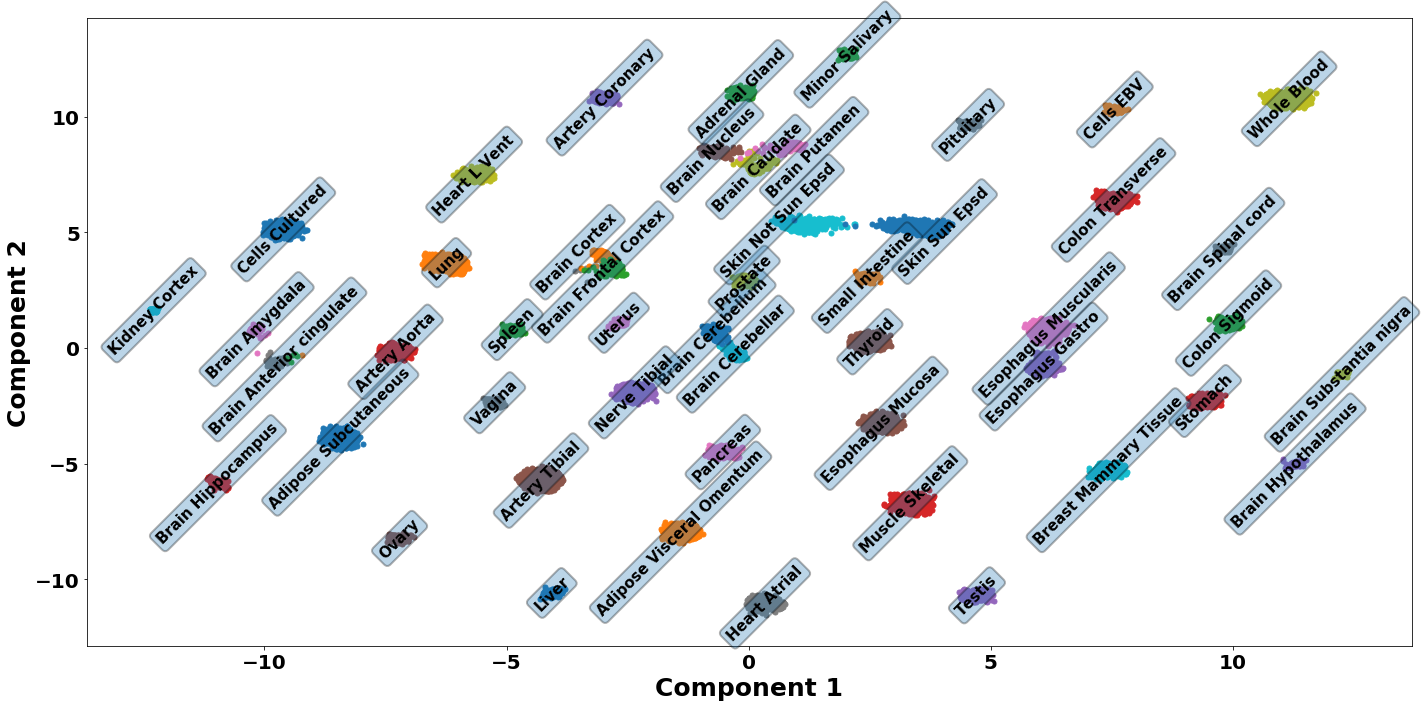

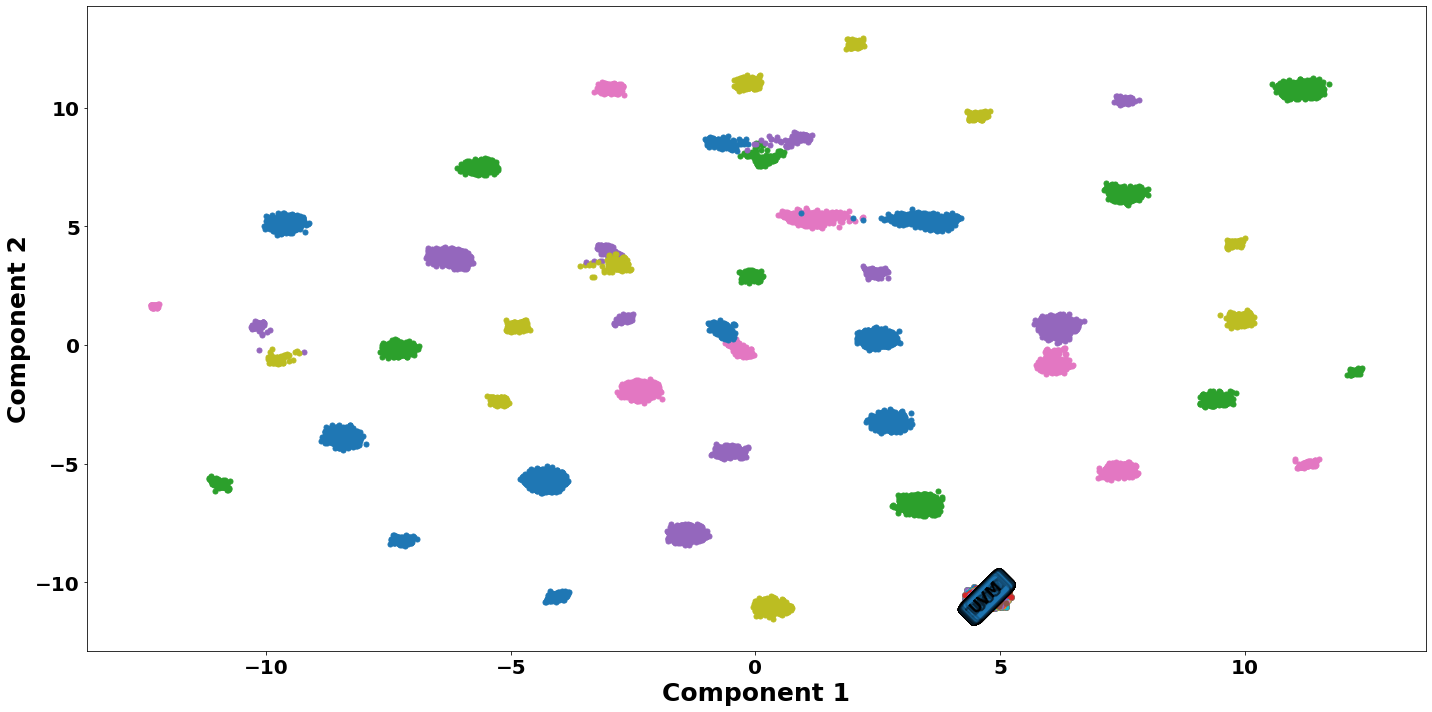

In [14]:
#https://matplotlib.org/users/annotations.html#plotting-guide-annotation
# Info about the column
no_labels = len(TISSUES)

for plot_id in range(2):
    plt.figure(figsize=(20,10))

    for i, tissue in enumerate(TISSUES):
        tmp_embedded = np.array(umap_embed.filter(like=tissue, axis=0))
        plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tissue)
        bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)

        x_text_coord = np.mean(tmp_embedded[:,0])
        y_text_coord = np.mean(tmp_embedded[:,1])
        if tissue in ['Brain_Cortex', 'Skin_Not_Sun_Epsd']:
            x_text_coord += -0.5
            y_text_coord += 0.2
        elif tissue in ['Brain_Putamen', 'Skin_Sun_Epsd']:
            x_text_coord += 0.5
            y_text_coord += -0.2
        if plot_id == 0:
            plt.text(x_text_coord, y_text_coord, tissue.replace('_', ' '), ha="center", va="center", 
                     rotation=45, fontweight='bold', backgroundcolor='white',
                    size=15,
                    bbox=bbox_props)
        else:

            for tcga_name, tcga_embed in TCGA_UMAPS.items():
                tmp_embedded = np.array(tcga_embed)
                plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tcga_name)
                bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)

                x_text_coord = np.mean(tmp_embedded[:,0])
                y_text_coord = np.mean(tmp_embedded[:,1])
                plt.text(x_text_coord, y_text_coord, tcga_name, ha="center", va="center", 
                         rotation=45, fontweight='bold', backgroundcolor='white',
                        size=15,
                        bbox=bbox_props)


    plt.xlabel('Component 1', fontweight='bold', size=25)
    plt.xticks(fontweight='bold', size=20)
    plt.yticks(fontweight='bold', size=20)
    plt.ylabel('Component 2', fontweight='bold', size=25)

    plt.tight_layout()
    #plt.savefig("figures/umap_master_matrix.png")
    plt.show()
    plt.close()

### Creating subset matrix to apply to TCGA

In [15]:
# submatrix
genes_existing = set()

for tissue in TISSUES:
    all_data = []
    indexes = []

    communities = pickle.load(open("results/louvain_modules_" + tissue + ".pkl", "rb"))

    try:
        for community_id in range(1, 999999):
            arr_com = []
            dic_community = pickle.load(open("svm_results/" + tissue + '_' + str(community_id) + ".pkl", "rb"))
            len_common = len(dic_community['genes'])
            if len_common <= 3:
                continue
                
            for gene in dic_community['genes']:
                genes_existing.add(gene)
    except Exception as e:
        pass

In [16]:
filtered_genes_df = all_df.loc[:, sorted(list(genes_existing))]
filtered_genes_df.shape

(15201, 3259)

In [17]:
umap_transformer_subset = umap.UMAP(n_neighbors=5,
                           min_dist=0.25,
                          learning_rate=0.5,
                          spread=1,
                          random_state=1111)

In [18]:
emb_2d = umap_transformer_subset.fit_transform(filtered_genes_df)
umap_embed_subset = pd.DataFrame(emb_2d, columns=['1', '2'], index=filtered_genes_df.index)

In [19]:
TCGA_UMAPS_SUBSET = {name_tissue: None for name_tissue in TCGA_TISSUES}

In [21]:
%%time

for name_tcga in TCGA_UMAPS_SUBSET.keys():
    tcga_df = pd.read_csv(f'data_filtered/only_geneids_CORRECTED_{name_tcga}.csv', index_col=0)
    tcga_df = tcga_df.loc[:, all_df.columns]
    
    tcga_df = tcga_df.sub(min_vals).div((max_vals - min_vals))
    tcga_df.fillna(0, inplace=True)
    
    tcga_df = tcga_df.loc[:, filtered_genes_df.columns]
    
    # Make gene expression values to cap between [0, 1] (given GTEx-learned transformations, TCGA values will not be in the same min/max range)
    # This is very inefficient and probably taking most of the running time of this cell
    tcga_df.transform(change_x)
    
    emb_2d = umap_transformer_subset.transform(tcga_df)
    TCGA_UMAPS_SUBSET[name_tcga] = pd.DataFrame(emb_2d, columns=['1', '2'], index=tcga_df.index)

CPU times: user 11min 39s, sys: 8.17 s, total: 11min 48s
Wall time: 11min 26s


### Running on subset matrix

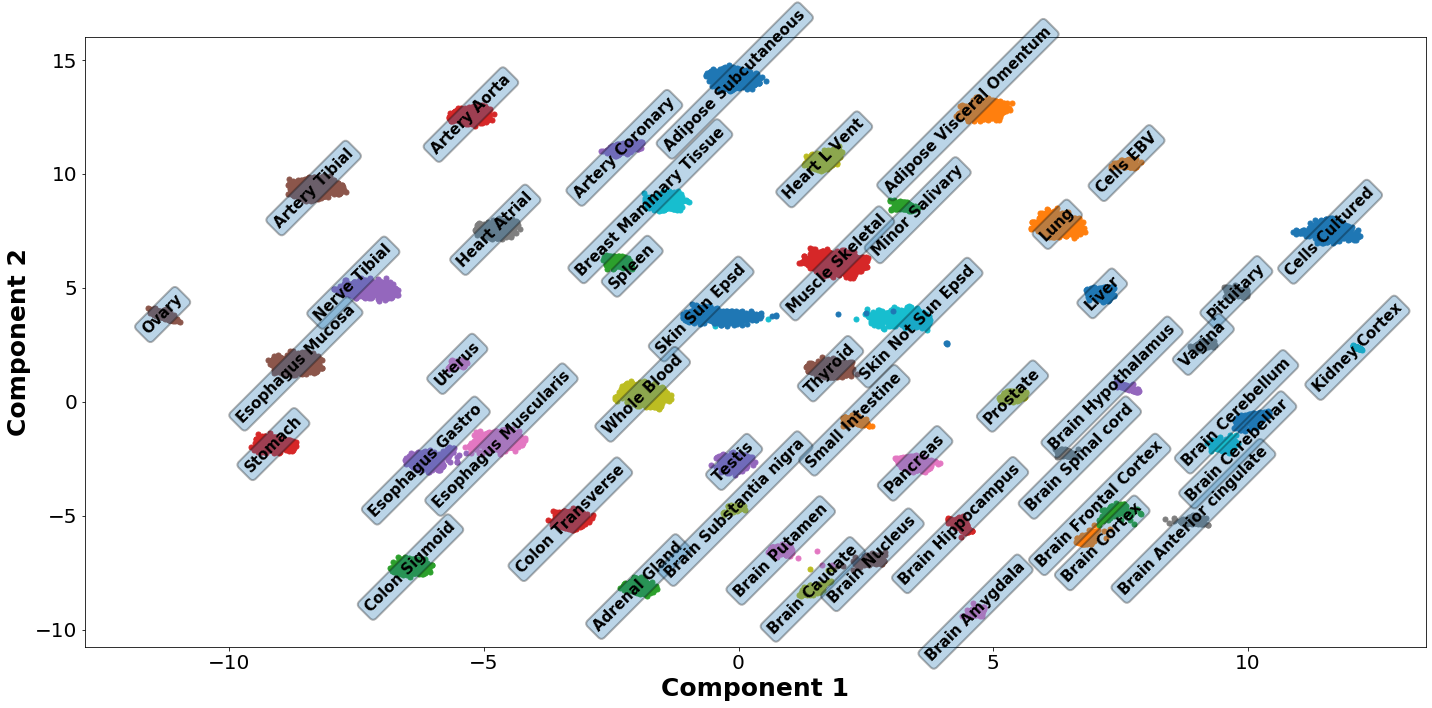

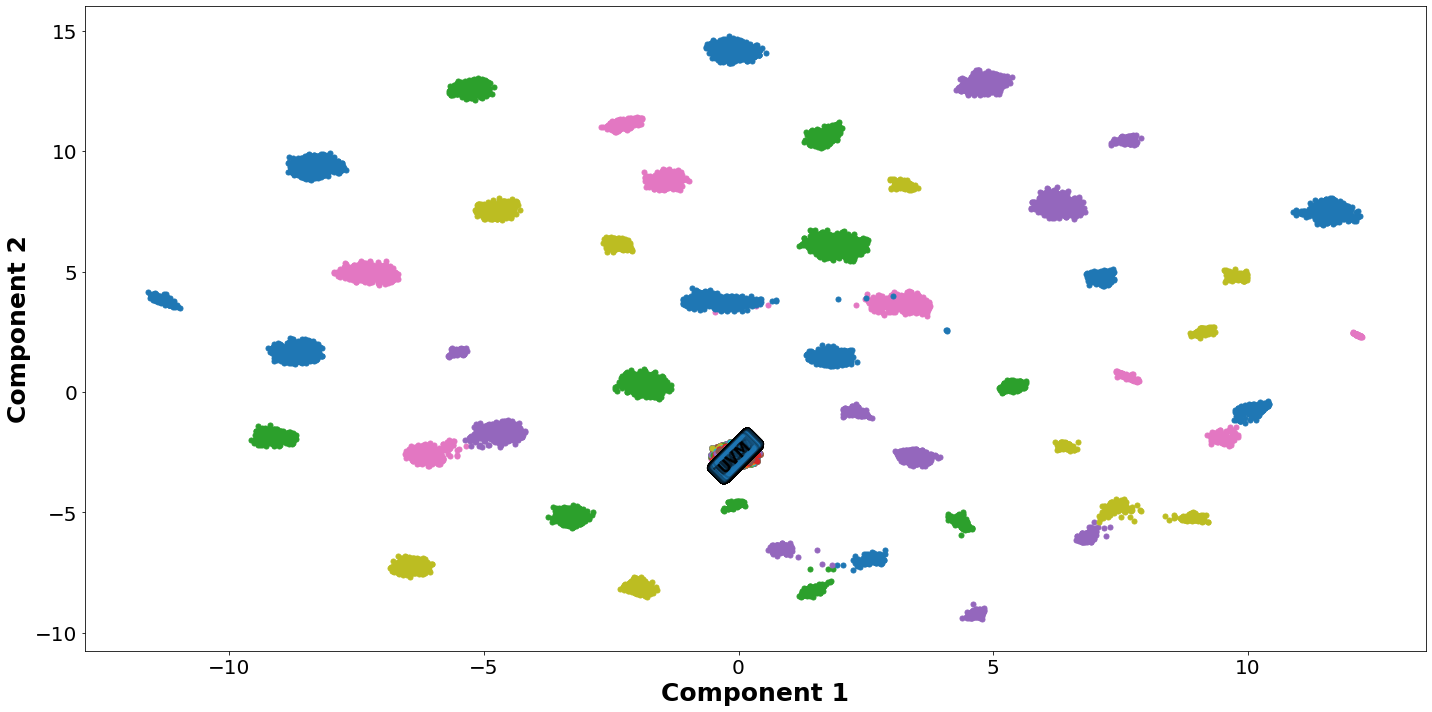

In [22]:
#https://matplotlib.org/users/annotations.html#plotting-guide-annotation
# Info about the column
no_labels = len(TISSUES)
for plot_id in range(2):    
    
    plt.figure(figsize=(20,10))

    for i, tissue in enumerate(TISSUES):
        tmp_embedded = np.array(umap_embed_subset.filter(like=tissue, axis=0))
        plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tissue)
        bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)

        x_text_coord = np.mean(tmp_embedded[:,0])
        y_text_coord = np.mean(tmp_embedded[:,1])
        if tissue in ['Adipose_Visceral_Omentum', 'Breast_Mammary_Tissue', 'Brain_Hypothalamus']:
            x_text_coord += -0.3
            #y_text_coord += 2
        elif tissue in ['Spleen', 'Minor_Salivary', 'Brain_Spinal_cord', 'Brain_Cerebellar', 'Brain_Cortex', 'Skin_Not_Sun_Epsd']:
            x_text_coord += 0.3
            y_text_coord += -0.2
        elif tissue in ['Brain_Cerebellum', 'Brain_Frontal_Cortex', 'Nerve_Tibial', 'Skin_Sun_Epsd']:
            x_text_coord += -0.3
            y_text_coord += 0.3
        if plot_id == 0:
            plt.text(x_text_coord, y_text_coord, tissue.replace('_', ' '), ha="center", va="center", 
                     rotation=45, fontweight='bold', backgroundcolor='white',
                    size=15,
                    bbox=bbox_props)
        else:
            for tcga_name, tcga_embed in TCGA_UMAPS_SUBSET.items():
                tmp_embedded = np.array(tcga_embed)
                plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tcga_name)
                bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)

                x_text_coord = np.mean(tmp_embedded[:,0])
                y_text_coord = np.mean(tmp_embedded[:,1])
                plt.text(x_text_coord, y_text_coord, tcga_name, ha="center", va="center", 
                         rotation=45, fontweight='bold', backgroundcolor='white',
                        size=15,
                        bbox=bbox_props)
    
    plt.xlabel('Component 1', fontweight='bold', size=25)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.ylabel('Component 2', fontweight='bold', size=25)

    plt.tight_layout()
    #plt.savefig("figures/umap_subgenes_matrix.png")
    plt.show()
    plt.close()

### Storing the UMAP embeddings

In [23]:
umap_embed.to_csv('data_filtered/umap_embeds_gtex_master_matrix.csv')
umap_embed_subset.to_csv('data_filtered/umap_embeds_gtex_subset_matrix.csv')

In [24]:
for tcga_name, tcga_df in TCGA_UMAPS_SUBSET.items():
    tcga_df.to_csv(f'data_filtered/umap_embeds_{tcga_name}_subset_matrix.csv')

for tcga_name, tcga_df in TCGA_UMAPS.items():
    tcga_df.to_csv(f'data_filtered/umap_embeds_{tcga_name}_master_matrix.csv')
    

## 3. UMAP on TCGA directly

In [2]:
TCGA_TISSUES = ['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']


### On entire matrix

In [3]:
%%time
# Creating the whole table
all_pandas = []
for f_name in sorted(TCGA_TISSUES):
    pd_tmp = pd.read_csv(f'data_filtered/only_geneids_CORRECTED_{f_name}.csv', index_col=0)
    pd_tmp.rename(index=lambda x: x + "_" + f_name, inplace=True)

    all_pandas.append(pd_tmp)

all_df = pd.concat(all_pandas, sort=False)

CPU times: user 3min 20s, sys: 4.78 s, total: 3min 25s
Wall time: 2min 38s


In [4]:
all_df.shape

(11057, 18797)

In [5]:
# Saving to transform TCGAs
max_vals = all_df.max().copy()
min_vals = all_df.min().copy()

In [6]:
all_df = all_df.sub(min_vals).div((max_vals - min_vals))

all_df.fillna(0, inplace=True)

In [8]:
umap_transformer = umap.UMAP(n_neighbors=5,
                           min_dist=0.25,
                          learning_rate=0.5,
                          spread=1,
                          random_state=1111)

In [9]:
%%time
emb_2d = umap_transformer.fit_transform(all_df)
umap_embed = pd.DataFrame(emb_2d, columns=['1', '2'], index=all_df.index)

CPU times: user 1min 10s, sys: 1.78 s, total: 1min 12s
Wall time: 1min 10s


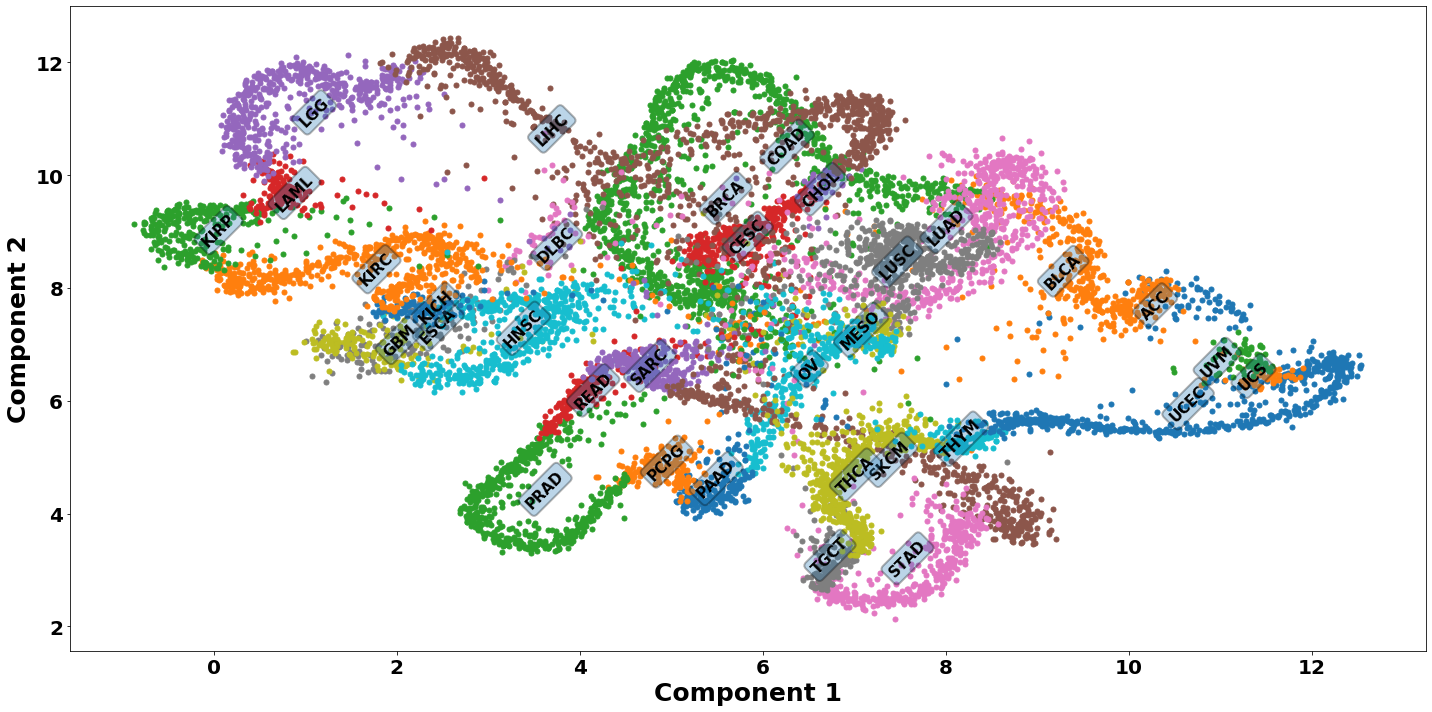

In [10]:
#https://matplotlib.org/users/annotations.html#plotting-guide-annotation
# Info about the column
no_labels = len(TCGA_TISSUES)

plt.figure(figsize=(20,10))

for i, tissue in enumerate(TCGA_TISSUES):
    tmp_embedded = np.array(umap_embed.filter(like=tissue, axis=0))
    plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tissue)
    bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)

    x_text_coord = np.mean(tmp_embedded[:,0])
    y_text_coord = np.mean(tmp_embedded[:,1])
    if tissue in ['Brain_Cortex', 'Skin_Not_Sun_Epsd']:
        x_text_coord += -0.5
        y_text_coord += 0.2
    elif tissue in ['Brain_Putamen', 'Skin_Sun_Epsd']:
        x_text_coord += 0.5
        y_text_coord += -0.2
    plt.text(x_text_coord, y_text_coord, tissue.replace('_', ' '), ha="center", va="center", 
             rotation=45, fontweight='bold', backgroundcolor='white',
            size=15,
            bbox=bbox_props)


plt.xlabel('Component 1', fontweight='bold', size=25)
plt.xticks(fontweight='bold', size=20)
plt.yticks(fontweight='bold', size=20)
plt.ylabel('Component 2', fontweight='bold', size=25)

plt.tight_layout()
#plt.savefig("figures/umap_master_matrix.png")
plt.show()
plt.close()

### On subset of genes defined from GTEx pipeline

In [7]:
# submatrix
genes_existing = set()

for tissue in TISSUES:
    all_data = []
    indexes = []

    communities = pickle.load(open("results/louvain_modules_" + tissue + ".pkl", "rb"))

    try:
        for community_id in range(1, 999999):
            arr_com = []
            dic_community = pickle.load(open("svm_results/" + tissue + '_' + str(community_id) + ".pkl", "rb"))
            len_common = len(dic_community['genes'])
            if len_common <= 3:
                continue
                
            for gene in dic_community['genes']:
                genes_existing.add(gene)
    except Exception as e:
        pass

In [8]:
filtered_genes_df = all_df.loc[:, sorted(list(genes_existing))]
filtered_genes_df.shape

(11057, 3259)

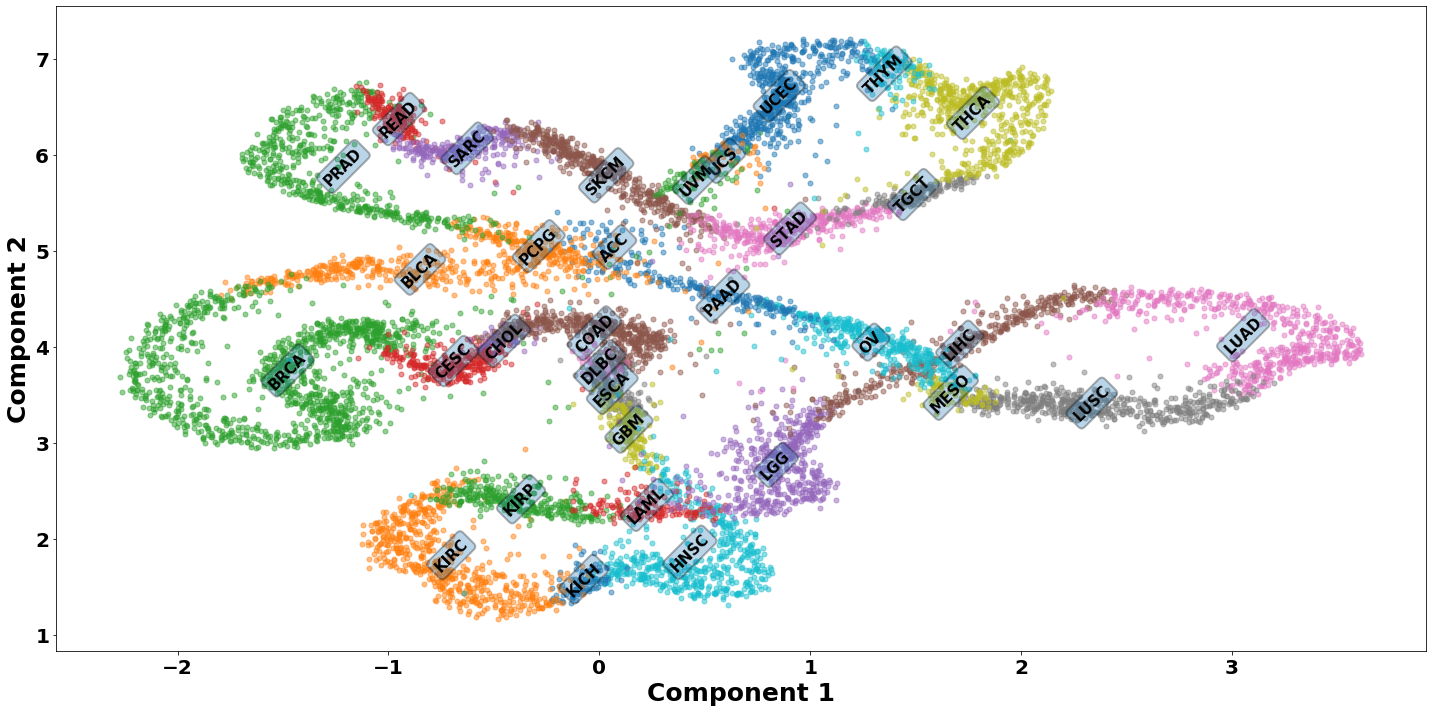

In [9]:
#https://matplotlib.org/users/annotations.html#plotting-guide-annotation
# Info about the column
no_labels = len(TCGA_TISSUES)

umap_transformer_subset = umap.UMAP(n_neighbors=5,
                           min_dist=0.25,
                          learning_rate=0.5,
                          spread=0.3,
                          random_state=1111)

emb_2d = umap_transformer_subset.fit_transform(filtered_genes_df)
umap_embed_subset = pd.DataFrame(emb_2d, columns=['1', '2'], index=filtered_genes_df.index)

plt.figure(figsize=(20,10))

for i, tissue in enumerate(TCGA_TISSUES):
    tmp_embedded = np.array(umap_embed_subset.filter(like=tissue, axis=0))
    plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tissue, alpha=0.5)
    bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)

    x_text_coord = np.mean(tmp_embedded[:,0])
    y_text_coord = np.mean(tmp_embedded[:,1])
    if tissue in ['Brain_Cortex', 'Skin_Not_Sun_Epsd']:
        x_text_coord += -0.5
        y_text_coord += 0.2
    elif tissue in ['Brain_Putamen', 'Skin_Sun_Epsd']:
        x_text_coord += 0.5
        y_text_coord += -0.2
    plt.text(x_text_coord, y_text_coord, tissue.replace('_', ' '), ha="center", va="center", 
             rotation=45, fontweight='bold', backgroundcolor='white',
            size=15,
            bbox=bbox_props)


plt.xlabel('Component 1', fontweight='bold', size=25)
plt.xticks(fontweight='bold', size=20)
plt.yticks(fontweight='bold', size=20)
plt.ylabel('Component 2', fontweight='bold', size=25)

plt.tight_layout()
plt.savefig("figures/umap_tcga_subset_matrix.png")
plt.show()
plt.close()

### Saving UMAP embeddings

In [21]:
umap_embed.to_csv('data_filtered/umap_embeds_tcga_entire_matrix.csv')
umap_embed_subset.to_csv('data_filtered/umap_embeds_tcga_subset_matrix.csv')

### TCGA UMAP Persistence - on embeddings from subset matix

In [18]:
from math import sqrt
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [19]:
%%time

BOOTSTRAP_RUNS = 500
global_distances = np.zeros((len(TCGA_TISSUES), len(TCGA_TISSUES)))
distance_vectors = defaultdict(list)

for run_i in range(BOOTSTRAP_RUNS):
    sampled_df = filtered_genes_df.sample(frac=0.8, replace=False, random_state=run_i)
    # To check status
    print(run_i, end=',')
    
    emb_2d = umap.UMAP(n_neighbors=5,
                       min_dist=0.25,
                       learning_rate=0.5,
                       spread=0.3,
                       random_state=1111).fit_transform(sampled_df)
    umap_embed = pd.DataFrame(emb_2d, columns=['1', '2'], index=sampled_df.index)
    
    for tissue1_i in range(len(TCGA_TISSUES)):
        tmp_embedded1 = np.array(umap_embed.filter(like=TCGA_TISSUES[tissue1_i], axis=0))

        x1 = np.mean(tmp_embedded1[:,0])
        y1 = np.mean(tmp_embedded1[:,1])

        for tissue2_i in range(tissue1_i+1, len(TCGA_TISSUES)):
            tmp_embedded2 = np.array(umap_embed.filter(like=TCGA_TISSUES[tissue2_i], axis=0))

            x2 = np.mean(tmp_embedded2[:,0])
            y2 = np.mean(tmp_embedded2[:,1])
            distance_value = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
        
            global_distances[tissue1_i, tissue2_i] += distance_value
            distance_vectors[f'{tissue1_i}-{tissue2_i}'].append(distance_value)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [41]:
# Saving everything
pd.DataFrame(distance_vectors).to_csv('results/tcga_distance_vectors.csv')
averaged_distances = global_distances / BOOTSTRAP_RUNS
np.save('results/tcga_averaged_distances.npy', averaged_distances)

averaged_distances[averaged_distances == 0] = np.nan

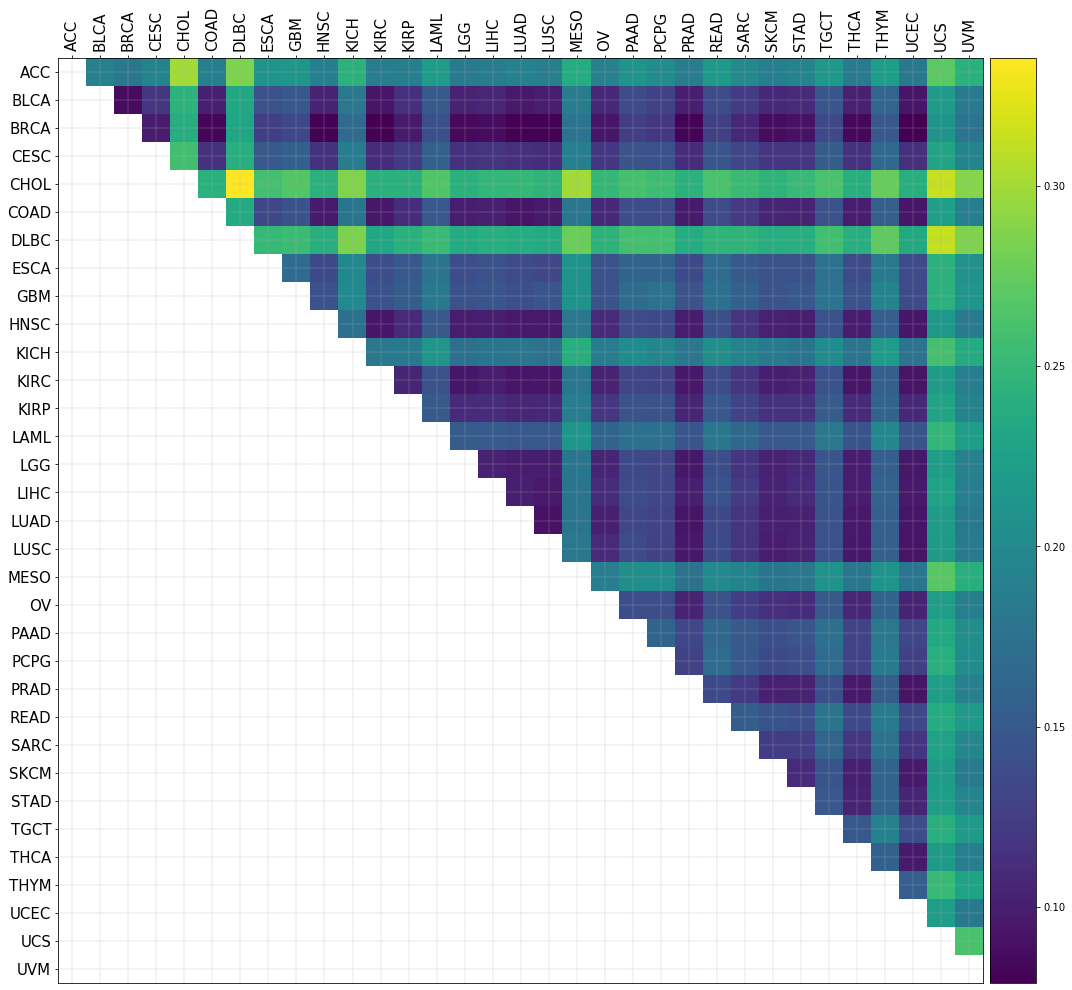

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.grid(linestyle='dashed', linewidth=0.4)
im = ax.imshow(averaged_distances)

ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

ax.set_xticks(np.arange(len(TCGA_TISSUES)))
ax.set_xticklabels([t.replace('_', ' ') for t in TCGA_TISSUES], size=15)

ax.set_yticks(np.arange(len(TCGA_TISSUES)))
ax.set_yticklabels([t.replace('_', ' ') for t in TCGA_TISSUES], size=15)
plt.setp(ax.get_xticklabels(), rotation=90)


# Making the colorbar nicely fit
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(im, cax=cax)
plt.tight_layout()

plt.savefig('figures/tcga_averaged_distances.pdf', bbox_inches = 'tight', pad_inches = 0)

plt.show()
plt.close()

### Checking some details on the averaged distances

In [36]:
np.nanmin(averaged_distances)

0.07895063392080572

In [58]:
averaged_distances[np.isnan(averaged_distances)] = 10
arr_tmp = np.where(averaged_distances < 0.09)
arr_tmp

(array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([ 2,  5,  9, 11, 14, 15, 16, 17, 22, 25, 28, 30]))

In [59]:
averaged_distances[averaged_distances == 10] = np.nan
pd.DataFrame(averaged_distances, index=TCGA_TISSUES, columns=TCGA_TISSUES).iloc[np.unique(arr_tmp[0]), arr_tmp[1]]

,BRCA,COAD,HNSC,KIRC,LGG,LIHC,LUAD,LUSC,PRAD,SKCM,THCA,UCEC
BLCA,0.085966,0.101250,0.10378,0.094091,0.103197,0.106746,0.096428,0.099202,0.100072,0.108989,0.102920,0.094753
BRCA,NaN,0.082426,0.08095,0.079047,0.085107,0.087847,0.079000,0.080803,0.081752,0.087398,0.084608,0.078951
